<a href="https://colab.research.google.com/github/gerryfrank10/Conser-Vision-Challenge/blob/main/model_pretraining_fastrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!rm -rf custom_images custom_images_1k

In [ ]:
import requests

!wget https://raw.githubusercontent.com/openimages/dataset/master/downloader.py

--2025-05-14 14:27:54--  https://raw.githubusercontent.com/openimages/dataset/master/downloader.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4244 (4.1K) [text/plain]
Saving to: ‘downloader.py’

downloader.py       100%[===================>]   4.14K  --.-KB/s    in 0s      

2025-05-14 14:27:55 (82.7 MB/s) - ‘downloader.py’ saved [4244/4244]



In [36]:
!ls

class-descriptions-boxable.csv	my_image_list.txt  subset-annotations.csv
downloader.py			sample_data	   train-annotations-bbox.csv


In [37]:
!python3 downloader.py --help

usage: downloader.py [-h] [--num_processes NUM_PROCESSES]
                     [--download_folder DOWNLOAD_FOLDER]
                     image_list

Open Images image downloader.

This script downloads a subset of Open Images images, given a list of image ids.
Typical uses of this tool might be downloading images:
- That contain a certain category.
- That have been annotated with certain types of annotations (e.g. Localized
Narratives, Exhaustively annotated people, etc.)

The input file IMAGE_LIST should be a text file containing one image per line
with the format <SPLIT>/<IMAGE_ID>, where <SPLIT> is either "train", "test",
"validation", or "challenge2018"; and <IMAGE_ID> is the image ID that uniquely
identifies the image in Open Images. A sample file could be:
  train/f9e0434389a1d4dd
  train/1a007563ebc18664
  test/ea8bfd4e765304db

positional arguments:
  image_list            Filename that contains the split + image IDs of the
                        images to download. Check the d

In [39]:
import pandas as pd


# Load class descriptions and get the label name for "Fork"
classes = pd.read_csv('https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv', header=None)
target_classes = ["Plate", "Spoon", "Book"]
target_labels = classes[classes[1].isin(target_classes)][0].tolist()

# Load annotations
annotations = pd.read_csv('https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv')
# Save to csv
annotations.to_csv('annotations.csv', index=False)
classes.to_csv('classes.csv', index=False)


# Filter by target class
filtered = annotations[annotations['LabelName'].isin(target_labels)]

# Get unique image IDs
image_ids = filtered['ImageID'].unique()

# Write to file with split prefix
with open('my_image_list.txt', 'w') as f:
    for img_id in image_ids:
        f.write(f"train/{img_id}\n")

In [40]:
!ls

downloader.py  my_image_list.txt  sample_data


In [41]:
!python downloader.py my_image_list.txt --download_folder=custom_images --num_processes=5

In [ ]:
!ls

custom_images  my_image_list.txt  train-annotations-bbox.csv
downloader.py  sample_data


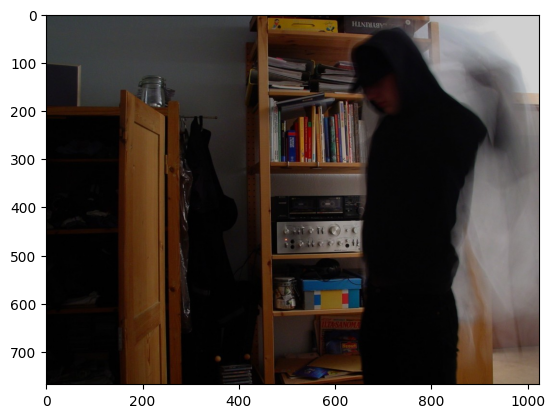

In [42]:
import cv2
import matplotlib.pyplot as plt

im = cv2.imread('custom_images/a1885292ff135541.jpg')[:,:,::-1]
plt.imshow(im);

In [ ]:
import os
import torch
from PIL import Image
import pandas as pd
from torchvision.transforms import functional as F

class OpenImagesDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation_csv, classes_csv, target_classes, transforms=None):
        self.root = root
        self.transforms = transforms
        self.annots = pd.read_csv(annotation_csv)
        self.classes = pd.read_csv(classes_csv, header=None)

        # Get target label codes
        self.target_classes = target_classes
        self.label_names = self.classes[self.classes[1].isin(target_classes)][0].tolist()

        # Filter only relevant annotations
        self.annots = self.annots[self.annots['LabelName'].isin(self.label_names)]

        self.image_ids = self.annots['ImageID'].unique()

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.root, image_id + '.jpg')
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        image_annots = self.annots[self.annots['ImageID'] == image_id]
        for _, row in image_annots.iterrows():
            xmin = row['XMin'] * img.width
            xmax = row['XMax'] * img.width
            ymin = row['YMin'] * img.height
            ymax = row['YMax'] * img.height
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.label_names.index(row['LabelName']) + 1)  # label indices start from 1

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx])}

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_ids)

In [44]:
with open('train-annotations-bbox.csv', 'wb') as f:
    f.write(requests.get('https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv').content)
with open('class-descriptions-boxable.csv', 'wb') as f:
    f.write(requests.get('https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv').content)

In [47]:
import os
import torch
from PIL import Image
import pandas as pd
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Custom Dataset
class OpenImagesDataset(Dataset):
    def __init__(self, root, annotation_csv, classes_csv, target_classes, transforms=None):
        self.root = root
        self.transforms = transforms
        self.annots = pd.read_csv(annotation_csv)
        self.classes = pd.read_csv(classes_csv, header=None)

        # Get target label codes
        self.target_classes = target_classes
        self.label_names = self.classes[self.classes[1].isin(target_classes)][0].tolist()

        # Filter only relevant annotations
        self.annots = self.annots[self.annots['LabelName'].isin(self.label_names)]
        self.image_ids = self.annots['ImageID'].unique()

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.root, image_id + '.jpg')
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        image_annots = self.annots[self.annots['ImageID'] == image_id]
        for _, row in image_annots.iterrows():
            xmin = row['XMin'] * img.width
            xmax = row['XMax'] * img.width
            ymin = row['YMin'] * img.height
            ymax = row['YMax'] * img.height
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.label_names.index(row['LabelName']) + 1)  # label indices start from 1

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx])}

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_ids)

# Transformations
transform = T.Compose([T.ToTensor()])

# Target classes
target_classes = ["Plate", "Spoon", "Book"]

# Dataset and DataLoader
dataset = OpenImagesDataset(
    root="custom_images_100",
    annotation_csv="subset-annotations.csv",
    classes_csv="class-descriptions-boxable.csv",
    target_classes=target_classes,
    transforms=transform
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)

# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the box predictor
num_classes = len(target_classes) + 1  # 3 classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move model to device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [3]:
import pandas as pd

# Load class descriptions and filter for target classes
target_classes = ["Plate", "Spoon", "Book"]
classes = pd.read_csv("class-descriptions-boxable.csv", header=None)
target_label_names = classes[classes[1].isin(target_classes)][0].tolist()

# Load full annotations
full_annots = pd.read_csv("train-annotations-bbox.csv")

# Filter annotations for only those target classes
filtered_annots = full_annots[full_annots['LabelName'].isin(target_label_names)]

# Select the first 1000 unique images
selected_image_ids = filtered_annots['ImageID'].unique()[:100]

# Filter annotations to only those 1000 images
subset_annots = filtered_annots[filtered_annots['ImageID'].isin(selected_image_ids)]

selected_image_ids = filtered_annots['ImageID'].unique()[:100]

# Filter annotations to only those 1000 images
subset_annots = filtered_annots[filtered_annots['ImageID'].isin(selected_image_ids)]

subset_annots.to_csv("subset-annotations.csv", index=False)

import os
import shutil

source_folder = "custom_images"
target_folder = "custom_images_100"
os.makedirs(target_folder, exist_ok=True)

for img_id in selected_image_ids:
    src_path = os.path.join(source_folder, f"{img_id}.jpg")
    dst_path = os.path.join(target_folder, f"{img_id}.jpg")
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)

FileNotFoundError: [Errno 2] No such file or directory: 'class-descriptions-boxable.csv'

In [2]:
from tqdm import tqdm, trange

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 5

for epoch in trange(num_epochs, desc="Epochs"):
    model.train()
    running_loss = 0.0

    for images, targets in tqdm(data_loader, desc=f"Training Epoch {epoch+1}", leave=False):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    avg_loss = running_loss / len(data_loader)
    print(f"Epoch {epoch+1} completed. Avg Loss: {avg_loss:.4f}")

NameError: name 'model' is not defined

In [ ]:
torch.save(model.state_dict(), 'faster_rcnn_model.pth')